In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ninadaithal/imagesoasis

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ninadaithal/imagesoasis
License(s): Apache 2.0
100% 1.23G/1.23G [01:06<00:00, 22.8MB/s]
100% 1.23G/1.23G [01:06<00:00, 19.8MB/s]


In [ ]:
!unzip imagesoasis.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_102.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_103.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_104.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_105.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_106.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_107.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_108.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_109.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_110.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_111.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_112.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_113.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_114.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_115.jpg  
  inflating

In [ ]:
!pip install transformers
!pip install datasets
!pip install torch
!pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 42.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py

In [ ]:
import os
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import ViTFeatureExtractor, ViTForImageClassification, AdamW
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')


class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, feature_extractor):
        self.image_paths = image_paths
        self.labels = labels
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.feature_extractor(images=image, return_tensors="pt")['pixel_values'].squeeze(0)
        label = torch.tensor(self.labels[idx])
        return image, label

main_dir = "/content/Data"
class_mapping = {"Mild Dementia": 0, "Moderate Dementia": 1, "Non Demented": 2, "Very mild Dementia": 3}

# Collect paths and labels
paths = []
labels = []

for class_name in os.listdir(main_dir):
    class_dir = os.path.join(main_dir, class_name)
    if os.path.isdir(class_dir):
        label = class_mapping.get(class_name)
        for img_name in os.listdir(class_dir):
            paths.append(os.path.join(class_dir, img_name))
            labels.append(label)

labels = np.array(labels)

class_lengths = [len(labels[labels == i]) for i in range(len(class_mapping))]

# Print the length of each class
for class_name, length in zip(class_mapping.keys(), class_lengths):
    print(f"Class '{class_name}': {length} samples")

#Target
target_samples = 13725  # As given, the count of class 3

balanced_paths = []
balanced_labels = []

for class_index in np.unique(labels):
    # Extract indices of each class
    class_indices = np.where(labels == class_index)[0]
    # Resample indices
    resampled_indices = resample(class_indices, replace=len(class_indices) < target_samples, n_samples=target_samples)
    # Append to lists
    balanced_paths.extend(paths[i] for i in resampled_indices)
    balanced_labels.extend(labels[i] for i in resampled_indices)

print("Balanced class sizes:")
for class_index in np.unique(balanced_labels):
    print(f"Class {class_index} ({list(class_mapping.keys())[list(class_mapping.values()).index(class_index)]}): {np.sum(np.array(balanced_labels) == class_index)}")


train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    balanced_paths,
    balanced_labels,
    test_size=0.3,  # Adjust this value as needed, 0.3 means 30% for validation and test
    random_state=42
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths,
    temp_labels,
    test_size=0.5,  # Split the 30% into half for validation and half for testing
    random_state=42
)


train_dataset = CustomDataset(train_paths, np.array(train_labels), feature_extractor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = CustomDataset(val_paths, np.array(val_labels), feature_extractor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = CustomDataset(test_paths, np.array(test_labels), feature_extractor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(np.unique(balanced_labels))  # Adapt this as per the number of unique labels in your dataset
)
model.to(device)

# The optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# epochs
epochs = 5

def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in dataloader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, dim=1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    training_accuracy = correct_predictions / total_predictions
    return avg_loss, training_accuracy


# Function to evaluate the model on the validation dataset
def evaluate(model, dataloader, device):
    model.eval()
    total_accuracy = 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images).logits
            _, predicted = torch.max(outputs, dim=1)
            total_accuracy += (predicted == labels).sum().item()

    accuracy = total_accuracy / len(dataloader.dataset)
    return accuracy

def train_with_validation(model, train_loader, val_loader, loss_fn, optimizer, device, epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0

        for batch in train_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).logits
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, dim=1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        avg_train_loss = total_loss / len(train_loader.dataset)
        training_accuracy = correct_predictions / total_predictions

        # Validation
        model.eval()
        total_val_loss = 0
        total_val_accuracy = 0

        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images).logits
                val_loss = loss_fn(outputs, labels)
                total_val_loss += val_loss.item()

                _, predicted = torch.max(outputs, dim=1)
                total_val_accuracy += (predicted == labels).sum().item()

        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_accuracy = total_val_accuracy / len(val_loader.dataset)

        # Store losses and accuracies
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(training_accuracy)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.10f}, Training Accuracy: {training_accuracy:.2%}, Validation Loss: {avg_val_loss:.10f}, Validation Accuracy: {val_accuracy:.2%}')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Loop through different training set sizes
training_set_sizes = [target_samples, int(target_samples * 0.8), int(target_samples * 0.6)]  # Example: Full size, 80%, 60%
for training_size in training_set_sizes:
    # Resample training set to match current size
    train_indices = resample(range(len(train_paths)), replace=False, n_samples=training_size)
    train_subset_paths = [train_paths[i] for i in train_indices]
    train_subset_labels = [train_labels[i] for i in train_indices]

    # Create DataLoader for the current training subset
    train_subset_dataset = CustomDataset(train_subset_paths, np.array(train_subset_labels), feature_extractor)
    train_subset_loader = DataLoader(train_subset_dataset, batch_size=32, shuffle=True)

    # Train and evaluate the model on the current training subset
    print(f"\nTraining with {training_size} samples:")
    train_losses, val_losses, train_accuracies, val_accuracies = train_with_validation(model, train_subset_loader, val_loader, loss_fn, optimizer, device, epochs)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Class 'Mild Dementia': 5002 samples
Class 'Moderate Dementia': 488 samples
Class 'Non Demented': 67222 samples
Class 'Very mild Dementia': 13725 samples
Balanced class sizes:
Class 0 (Mild Dementia): 13725
Class 1 (Moderate Dementia): 13725
Class 2 (Non Demented): 13725
Class 3 (Very mild Dementia): 13725


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Training with 13725 samples:
Epoch 1/5, Training Loss: 0.0135342122, Training Accuracy: 84.20%, Validation Loss: 0.0052600066, Validation Accuracy: 95.11%
Epoch 2/5, Training Loss: 0.0040888888, Training Accuracy: 95.88%, Validation Loss: 0.0025846626, Validation Accuracy: 97.36%
Epoch 3/5, Training Loss: 0.0017157453, Training Accuracy: 98.43%, Validation Loss: 0.0029050019, Validation Accuracy: 97.22%
Epoch 4/5, Training Loss: 0.0013197365, Training Accuracy: 98.75%, Validation Loss: 0.0033317258, Validation Accuracy: 96.98%
Epoch 5/5, Training Loss: 0.0005553669, Training Accuracy: 99.53%, Validation Loss: 0.0020048697, Validation Accuracy: 98.07%

Training with 10980 samples:
Epoch 1/5, Training Loss: 0.0011741803, Training Accuracy: 98.77%, Validation Loss: 0.0010608816, Validation Accuracy: 98.89%
Epoch 2/5, Training Loss: 0.0008155790, Training Accuracy: 99.26%, Validation Loss: 0.0009382566, Validation Accuracy: 98.98%
Epoch 3/5, Training Loss: 0.0007304248, Training Accuracy:

In [ ]:
def get_predictions(model, dataloader, device):
    model.eval()
    predictions = []
    probabilities = []
    true_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images).logits
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)
            predictions.extend(preds.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, probabilities, true_labels

# Get predictions and calculate accuracy
predictions, probabilities, true_labels = get_predictions(model, test_loader, device)
accuracy = (np.array(predictions) == np.array(true_labels)).mean()
print(f"Model Accuracy: {accuracy:.2%}")

Model Accuracy: 97.41%


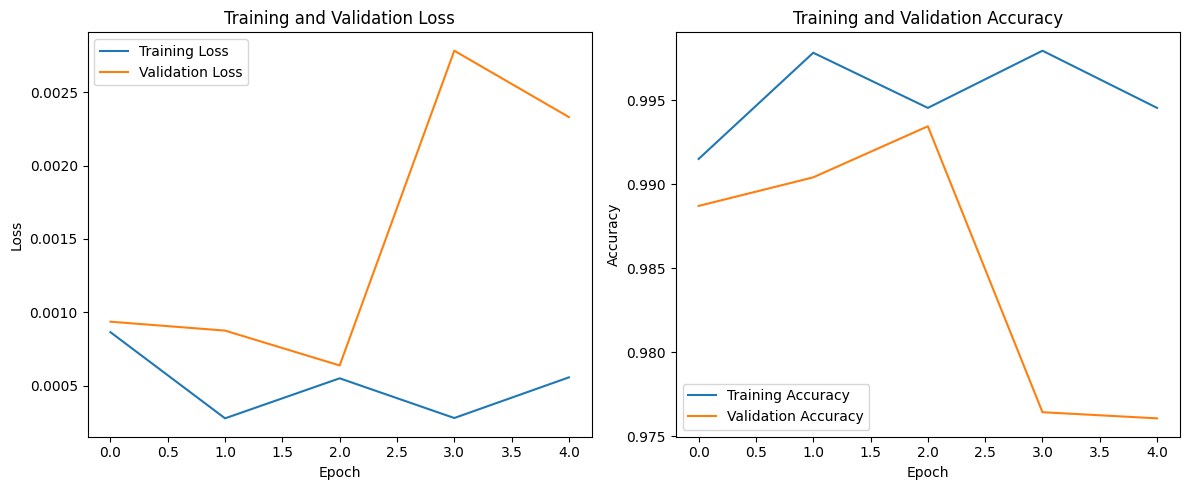

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')  # Add validation loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

Confusion Matrix


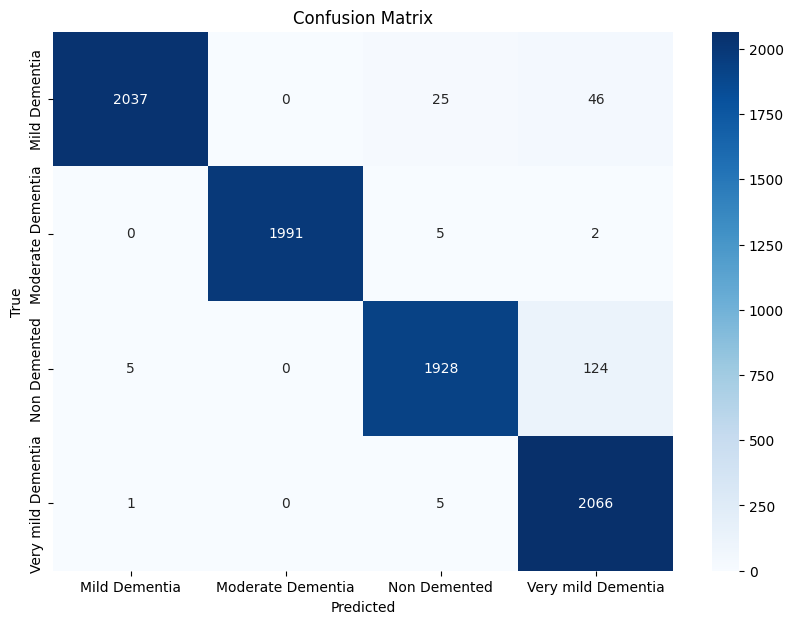

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, log_loss
import seaborn as sns
print("Confusion Matrix")
class_names = {"Mild Dementia": 0, "Moderate Dementia": 1, "Non Demented": 2, "Very mild Dementia": 3}
# Generate and display the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Print the classification report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=class_names.keys()))

Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia       1.00      0.97      0.98      2108
 Moderate Dementia       1.00      1.00      1.00      1998
      Non Demented       0.98      0.94      0.96      2057
Very mild Dementia       0.92      1.00      0.96      2072

          accuracy                           0.97      8235
         macro avg       0.98      0.97      0.97      8235
      weighted avg       0.98      0.97      0.97      8235



In [ ]:
roc_auc_ovo = roc_auc_score(true_labels, probabilities, multi_class='ovo')  # Requires probability scores
roc_auc_ovr = roc_auc_score(true_labels, probabilities, multi_class='ovr')
cross_entropy_loss = log_loss(true_labels, probabilities)  # Also requires probabilities


In [ ]:
print(f"ROC AUC (One-vs-One): {roc_auc_ovo:.2f}")
print(f"ROC AUC (One-vs-Rest): {roc_auc_ovr:.2f}")
print("Cross-entropy Loss:", cross_entropy_loss)


ROC AUC (One-vs-One): 1.00
ROC AUC (One-vs-Rest): 1.00
Cross-entropy Loss: 0.07338964274759809
